In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             accuracy_score)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from collections import Counter

# ====== CONFIGURATION ======
class Config:
    BATCH_SIZE = 8
    IMG_SIZE = (227, 227)  # AlexNet input size
    NUM_FOLDS = 5
    EPOCHS = 50
    LEARNING_RATE = 1e-4  # AlexNet used a higher learning rate initially
    DROPOUT_RATE = 0.5
    BASE_DIR = '/kaggle/input/local-preprocessed-dataset/LOCAL PREPROCESSED DATASET'
    SEED = 42
    MIN_SAMPLES = 20

# ====== DATA AUGMENTATION ======
def create_augmenter():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  # Adjusted for AlexNet-like augmentation
        width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest',
        validation_split=0.2
    )

# ====== ALEXNET MODEL ======
def build_alexnet(num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(*Config.IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),

        layers.Flatten(),
        layers.Dropout(Config.DROPOUT_RATE),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(Config.DROPOUT_RATE),
        layers.Dense(4096, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = optimizers.Adam(
        learning_rate=Config.LEARNING_RATE
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )
    return model

# ====== CUSTOM DATA GENERATOR ======
class AdvancedDataGenerator(Sequence):
    def __init__(self, filepaths, labels, datagen, batch_size=32, img_size=(227, 227), shuffle=True):
        self.filepaths = filepaths
        self.labels = labels
        self.datagen = datagen
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.filepaths) / self.batch_size)

    def __getitem__(self, index):
        batch_files = self.filepaths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for filepath in batch_files:
            img = image.load_img(filepath, target_size=self.img_size)
            img_array = image.img_to_array(img)
            img_array = self.datagen.standardize(img_array)
            images.append(img_array)

        return np.array(images), tf.keras.utils.to_categorical(batch_labels, num_classes=len(set(self.labels)))

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.filepaths))
            np.random.shuffle(indices)
            self.filepaths = [self.filepaths[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]

# ====== TRAINING PIPELINE ======
def run_training():
    # Initialize data
    datagen = create_augmenter()

    train_gen = datagen.flow_from_directory(
        Config.BASE_DIR,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=Config.SEED
    )

    # Data integrity checks
    print("\n=== DATA VALIDATION ===")
    print("Class distribution in training:", Counter(train_gen.labels))

    val_gen = datagen.flow_from_directory(
        Config.BASE_DIR,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=Config.SEED
    )
    print("Class distribution in validation:", Counter(val_gen.labels))

    # Verify no overlap
    train_files = set(train_gen.filepaths)
    val_files = set(val_gen.filepaths)
    print(f"Number of overlapping files: {len(train_files & val_files)}")

    class_indices = train_gen.class_indices
    X = train_gen.filepaths
    y = train_gen.labels

    # Cross-validation setup
    kf = KFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=Config.SEED)
    fold_no = 1
    history_list = []
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }

    for train_idx, val_idx in kf.split(X, y):
        print(f"\n🔵 Fold {fold_no}")

        # Create generators
        simple_datagen = ImageDataGenerator(rescale=1./255)
        train_data = AdvancedDataGenerator(
            [X[i] for i in train_idx],
            [y[i] for i in train_idx],
            simple_datagen,
            Config.BATCH_SIZE,
            Config.IMG_SIZE
        )
        val_data = AdvancedDataGenerator(
            [X[i] for i in val_idx],
            [y[i] for i in val_idx],
            simple_datagen,
            Config.BATCH_SIZE,
            Config.IMG_SIZE,
            shuffle=False
        )

        # Build model - changed to AlexNet
        model = build_alexnet(len(class_indices))

        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_auc',
                patience=15,
                mode='max',
                baseline=0.85,
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=8,
                min_lr=1e-6,
                cooldown=2
            ),
            callbacks.ModelCheckpoint(
                f'alexnet_fold_{fold_no}.keras',  # Changed filename to alexnet
                monitor='val_auc',
                save_best_only=True,
                mode='max'
            )
        ]

        # Train
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=Config.EPOCHS,
            callbacks=callbacks_list,
            verbose=1
        )
        history_list.append(history)

        # Evaluate
        val_preds = model.predict(val_data, verbose=0)
        val_preds_labels = np.argmax(val_preds, axis=1)
        val_true_labels = val_data.labels

        # Store metrics
        metrics['accuracy'].append(accuracy_score(val_true_labels, val_preds_labels))
        metrics['precision'].append(precision_score(val_true_labels, val_preds_labels, average='weighted'))
        metrics['recall'].append(recall_score(val_true_labels, val_preds_labels, average='weighted'))
        metrics['f1'].append(f1_score(val_true_labels, val_preds_labels, average='weighted'))
        metrics['auc'].append(np.mean(history.history['val_auc'][-5:]))

        print(f"✅ Fold {fold_no} Results:")
        print(f"Accuracy: {metrics['accuracy'][-1]*100:.2f}%")
        print(f"AUC: {metrics['auc'][-1]:.4f}")

        fold_no += 1
        tf.keras.backend.clear_session()
        gc.collect()

    # Final results
    print("\n=== CROSS-VALIDATION RESULTS ===")
    for metric, values in metrics.items():
        print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

    return history_list, metrics, class_indices, X, y

# ====== VISUALIZATION ======
def plot_results(history_list, metrics, class_indices, X, y):
    # Training curves
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    for i, history in enumerate(history_list):
        plt.plot(history.history['accuracy'], linestyle='--', alpha=0.3, color='blue')
        plt.plot(history.history['val_accuracy'], alpha=0.3, color='orange')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    for i, history in enumerate(history_list):
        plt.plot(history.history['loss'], linestyle='--', alpha=0.3, color='blue')
        plt.plot(history.history['val_loss'], alpha=0.3, color='orange')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    # Confusion matrix for best fold
    best_fold = np.argmax(metrics['auc']) + 1
    model = tf.keras.models.load_model(f'alexnet_fold_{best_fold}.keras')  # Changed to alexnet

    # Get validation data for best fold
    kf = KFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=Config.SEED)
    splits = list(kf.split(X, y))
    _, val_idx = splits[best_fold - 1]

    val_data = AdvancedDataGenerator(
        [X[i] for i in val_idx],
        [y[i] for i in val_idx],
        ImageDataGenerator(rescale=1./255),
        Config.BATCH_SIZE,
        Config.IMG_SIZE,
        shuffle=False
    )

    val_preds = model.predict(val_data)
    val_preds_labels = np.argmax(val_preds, axis=1)

    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(val_data.labels, val_preds_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_indices.keys(),
                yticklabels=class_indices.keys())
    plt.title(f'AlexNet Confusion Matrix (Fold {best_fold})')  # Changed to AlexNet
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



Found 400 images belonging to 5 classes.

=== DATA VALIDATION ===
Class distribution in training: Counter({0: 80, 1: 80, 2: 80, 3: 80, 4: 80})
Found 100 images belonging to 5 classes.
Class distribution in validation: Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20})
Number of overlapping files: 0

🔵 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.2474 - auc: 0.5378 - loss: 2.3672 - precision: 0.2398 - recall: 0.1426 - val_accuracy: 0.2750 - val_auc: 0.5389 - val_loss: 1.6000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.3543 - auc: 0.6402 - loss: 1.5343 - precision: 0.7019 - recall: 0.1153 - val_accuracy: 0.2750 - val_auc: 0.5666 - val_loss: 1.6588 - val_precision: 0.5000 - val_recall: 0.0125 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5435 - auc: 0.8223 - loss: 1.1831 - precision: 0.8044 - recall: 0.2676 - val_accuracy: 0.2125 - val_auc: 0.5683 - val_loss: 1.8306 - val_precision: 0.5000 - val_recall: 0.0125 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.5960 - auc: 0.8732 - loss: 0.9882 - precision: 0.7868 - recall: 0.4785 - val_accuracy: 0.2750 - val_auc: 0.6031 - val_loss: 2.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.1195 - auc: 0.4625 - loss: 3.0137 - precision: 0.0858 - recall: 0.0458 - val_accuracy: 0.3625 - val_auc: 0.5610 - val_loss: 1.6046 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4082 - auc: 0.6896 - loss: 1.4314 - precision: 0.7721 - recall: 0.1222 - val_accuracy: 0.2000 - val_auc: 0.5242 - val_loss: 1.7648 - val_precision: 0.5000 - val_recall: 0.0250 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5255 - auc: 0.8105 - loss: 1.1684 - precision: 0.8341 - recall: 0.3313 - val_accuracy: 0.2000 - val_auc: 0.5657 - val_loss: 1.9226 - val_precision: 0.2000 - val_recall: 0.2000 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6408 - auc: 0.8913 - loss: 0.9359 - precision: 0.8009 - recall: 0.4733 - val_accuracy: 0.2000 - val_auc: 0.5582 - val_loss: 1.82

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.2482 - auc: 0.5432 - loss: 2.6012 - precision: 0.2322 - recall: 0.1221 - val_accuracy: 0.1375 - val_auc: 0.4567 - val_loss: 1.6186 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3992 - auc: 0.6698 - loss: 1.5392 - precision: 0.6016 - recall: 0.0972 - val_accuracy: 0.1125 - val_auc: 0.4302 - val_loss: 2.0487 - val_precision: 0.1169 - val_recall: 0.1125 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.4140 - auc: 0.7757 - loss: 1.2714 - precision: 0.7500 - recall: 0.1724 - val_accuracy: 0.1125 - val_auc: 0.4841 - val_loss: 2.2937 - val_precision: 0.1125 - val_recall: 0.1125 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5897 - auc: 0.8816 - loss: 0.9496 - precision: 0.7307 - recall: 0.4519 - val_accuracy: 0.1125 - val_auc: 0.4595 - val_loss: 2.49

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.2035 - auc: 0.5016 - loss: 2.4513 - precision: 0.1791 - recall: 0.0966 - val_accuracy: 0.2000 - val_auc: 0.5331 - val_loss: 1.5999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3270 - auc: 0.6721 - loss: 1.4760 - precision: 0.8201 - recall: 0.1084 - val_accuracy: 0.1750 - val_auc: 0.5299 - val_loss: 1.7755 - val_precision: 0.3333 - val_recall: 0.0250 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.4404 - auc: 0.7503 - loss: 1.3314 - precision: 0.8081 - recall: 0.1741 - val_accuracy: 0.2375 - val_auc: 0.5700 - val_loss: 2.0147 - val_precision: 0.2375 - val_recall: 0.2375 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5503 - auc: 0.8480 - loss: 1.0707 - precision: 0.8288 - recall: 0.3658 - val_accuracy: 0.1750 - val_auc: 0.5640 - val_loss: 1.94

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.1966 - auc: 0.4891 - loss: 2.8372 - precision: 0.2258 - recall: 0.0908 - val_accuracy: 0.2375 - val_auc: 0.5145 - val_loss: 1.6106 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3409 - auc: 0.6850 - loss: 1.4348 - precision: 0.7728 - recall: 0.1336 - val_accuracy: 0.1625 - val_auc: 0.5031 - val_loss: 1.7025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5661 - auc: 0.8270 - loss: 1.1554 - precision: 0.8158 - recall: 0.3290 - val_accuracy: 0.1625 - val_auc: 0.5054 - val_loss: 1.8582 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.6116 - auc: 0.8894 - loss: 0.9500 - precision: 0.7829 - recall: 0.4525 - val_accuracy: 0.1750 - val_auc: 0.5435 

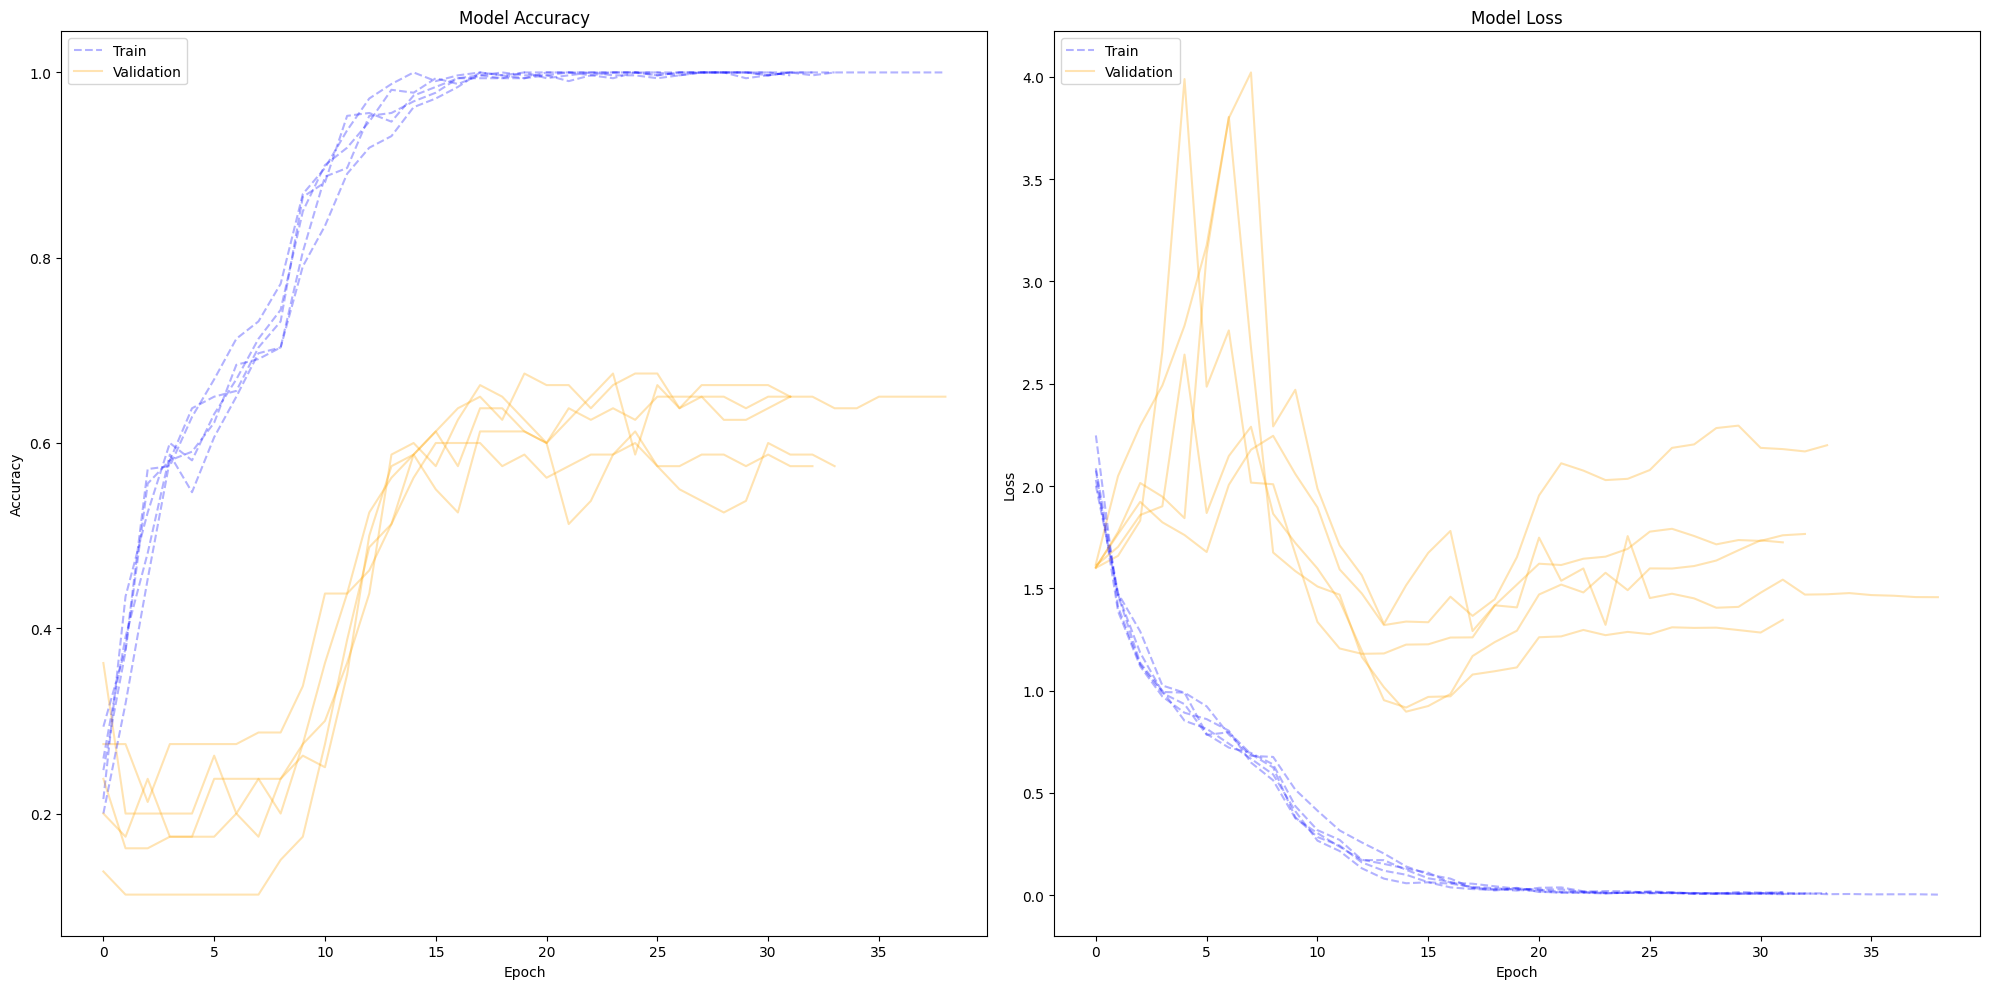

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


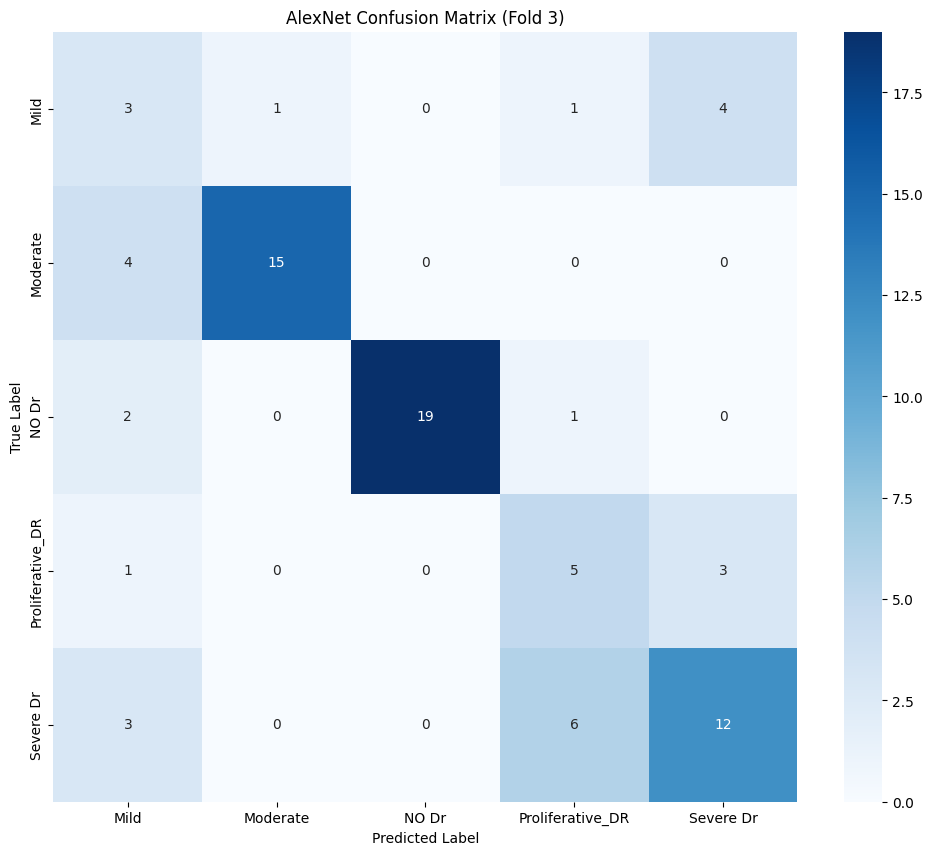


Making prediction on test image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


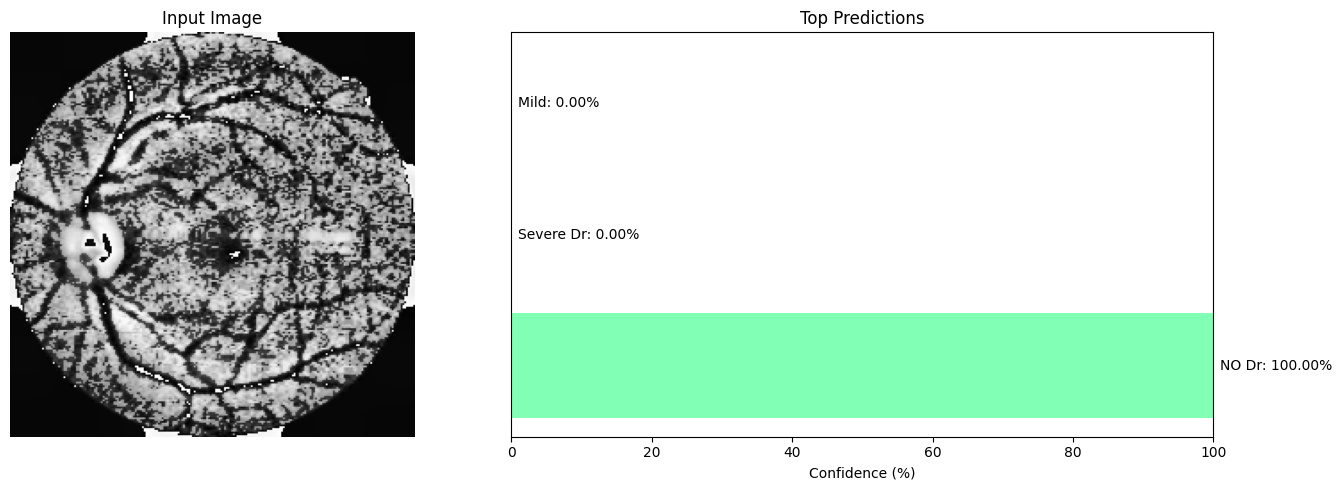


Prediction Probabilities:
NO Dr: 100.00%
Severe Dr: 0.00%
Mild: 0.00%
Moderate: 0.00%
Proliferative_DR: 0.00%


In [9]:
# ====== PREDICTION UTILITIES ======
class AlexNetPredictor:  # Changed class name to reflect the model

    def __init__(self, model_path, class_indices):
        self.model = tf.keras.models.load_model(model_path)
        self.class_indices = class_indices
        self.img_size = Config.IMG_SIZE

    def predict_image(self, image_path):
        """Make prediction with visualization."""
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        img = image.load_img(image_path, target_size=self.img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = self.model.predict(img_array)[0]
        sorted_idx = np.argsort(pred)[::-1]

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Input Image')

        plt.subplot(1, 2, 2)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.class_indices)))
        for i, idx in enumerate(sorted_idx[:3]):
            plt.barh(i, pred[idx] * 100, color=colors[idx])
            plt.text(pred[idx] * 100 + 1, i,
                     f"{list(self.class_indices.keys())[idx]}: {pred[idx] * 100:.2f}%",
                     va='center')
        plt.yticks([])
        plt.xlabel('Confidence (%)')
        plt.title('Top Predictions')
        plt.xlim(0, 100)
        plt.tight_layout()
        plt.show()

        return {list(self.class_indices.keys())[i]: float(pred[i]) for i in sorted_idx}

# ====== MAIN EXECUTION ======
if __name__ == "__main__":
    # Run training
    history_list, metrics, class_indices, X, y = run_training()
    # Visualize results
    plot_results(history_list, metrics, class_indices, X, y)

    # Example prediction
    predictor = AlexNetPredictor('alexnet_fold_1.keras', class_indices)  # Changed to alexnet
    test_image = os.path.join(Config.BASE_DIR, 'NO Dr/005b95c28852.png')

    if os.path.exists(test_image):
        print("\nMaking prediction on test image...")
        predictions = predictor.predict_image(test_image)
        print("\nPrediction Probabilities:")
        for cls, prob in predictions.items():
            print(f"{cls}: {prob * 100:.2f}%")
    else:
        print(f"\nTest image not found at: {test_image}")
        print("Please provide a valid image path for prediction.")